<a href="https://colab.research.google.com/github/yeho/scikit-learn-AI/blob/master/LIDAR_vehiculo_autonomo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

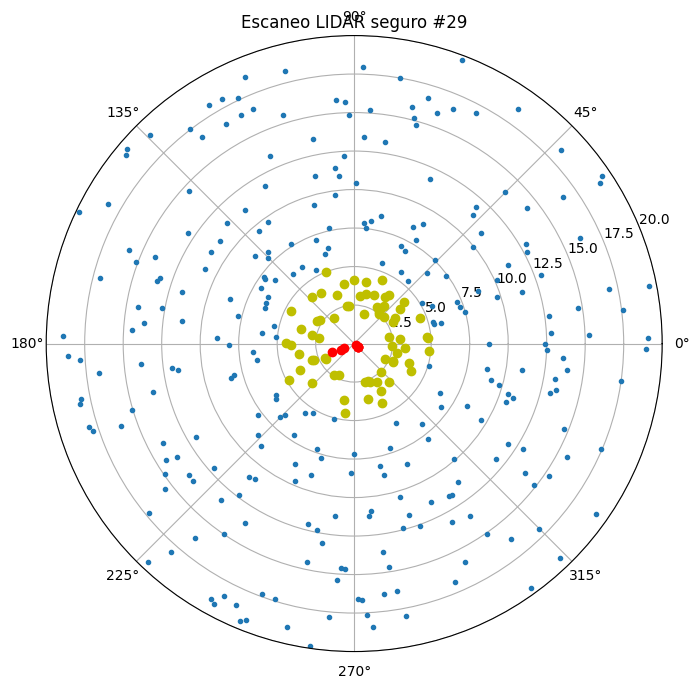

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import datetime

# Parámetros
N_PUNTOS = 360
DIST_MIN, DIST_MAX = 2, 20
UMBRAL_PELIGRO = 5
UMBRAL_CRITICO = 2
REDUNDANCIA = 5   # lecturas por escaneo
np.random.seed(42)

# --- Seguridad: logging ---
def log_evento(mensaje):
    timestamp = datetime.datetime.now().isoformat()
    with open("seguridad_lidar.log", "a") as f:
        f.write(f"[{timestamp}] {mensaje}\n")

# --- Obstáculos fijos (más realista) ---
escenario_base = np.random.uniform(DIST_MIN, DIST_MAX, size=N_PUNTOS)
# Colocamos obstáculos persistentes
escenario_base[50:55] = np.random.uniform(1.5, 4, size=5)
escenario_base[200:205] = np.random.uniform(0.5, 3, size=5)

# Variable global para simular ataques que duren varios frames
ataque_activo = {"sector": None, "frames_restantes": 0}

def simular_lectura_lidar():
    """Simula una lectura LIDAR en 360° con ruido, obstáculos persistentes y ataques."""
    global ataque_activo
    angulos = np.linspace(0, 2*np.pi, N_PUNTOS)
    distancias = escenario_base.copy()

    # Ruido normal (pequeño, más realista)
    distancias += np.random.normal(0, 0.1, size=N_PUNTOS)

    # Ataque spoofing con duración
    if ataque_activo["frames_restantes"] > 0:
        sector = ataque_activo["sector"]
        distancias[sector:sector+5] = np.random.uniform(0.1, 0.5, size=5)
        ataque_activo["frames_restantes"] -= 1
    elif np.random.rand() < 0.1:  # 10% prob de iniciar un ataque
        sector = np.random.randint(0, N_PUNTOS-10)
        ataque_activo["sector"] = sector
        ataque_activo["frames_restantes"] = np.random.randint(3, 6) # dura varios frames
        log_evento(f"⚠️ Posible ataque spoofing iniciado en sector {sector}-{sector+5}")

    return angulos, distancias

def lectura_redundante(n_repeticiones=REDUNDANCIA):
    """Promedia varias lecturas LIDAR para mayor confiabilidad."""
    lecturas = []
    for _ in range(n_repeticiones):
        _, distancias = simular_lectura_lidar()
        lecturas.append(distancias)
    distancias_prom = np.mean(lecturas, axis=0)
    angulos = np.linspace(0, 2*np.pi, N_PUNTOS)
    return angulos, distancias_prom, lecturas

def detectar_obstaculos(angulos, distancias):
    """Clasifica obstáculos en seguros, peligrosos y críticos."""
    seguros = np.where(distancias >= UMBRAL_PELIGRO)[0]
    peligrosos = np.where((distancias < UMBRAL_PELIGRO) & (distancias >= UMBRAL_CRITICO))[0]
    criticos = np.where(distancias < UMBRAL_CRITICO)[0]
    return seguros, peligrosos, criticos

def detectar_anomalias(lecturas):
    """Detecta inconsistencias entre lecturas redundantes (ataques/anomalías)."""
    varianza = np.var(lecturas, axis=0)
    # umbral más relajado, solo si hay cambios grandes
    anomalias = np.where(varianza > 1.0)[0]
    if len(anomalias) > 0:
        log_evento(f"⚠️ Anomalías detectadas en ángulos: {anomalias.tolist()}")
    return anomalias

# --- Animación en tiempo real ---
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, projection="polar")
ax.set_rmax(DIST_MAX)

linea, = ax.plot([], [], ".", label="LIDAR")
puntos_peligro, = ax.plot([], [], "yo", label="Peligro (<5m)")
puntos_critico, = ax.plot([], [], "ro", label="Crítico (<2m)")
puntos_anomalia, = ax.plot([], [], "mx", label="Anomalía/Spoofing")

def init():
    linea.set_data([], [])
    puntos_peligro.set_data([], [])
    puntos_critico.set_data([], [])
    puntos_anomalia.set_data([], [])
    return linea, puntos_peligro, puntos_critico, puntos_anomalia

def update(frame):
    angulos, distancias, lecturas = lectura_redundante()
    seguros, peligrosos, criticos = detectar_obstaculos(angulos, distancias)
    anomalias = detectar_anomalias(lecturas)

    # Actualizar trazos
    linea.set_data(angulos, distancias)
    puntos_peligro.set_data(angulos[peligrosos], distancias[peligrosos])
    puntos_critico.set_data(angulos[criticos], distancias[criticos])
    puntos_anomalia.set_data(angulos[anomalias], distancias[anomalias])

    ax.set_title(f"Escaneo LIDAR seguro #{frame}")
    return linea, puntos_peligro, puntos_critico, puntos_anomalia

ani = FuncAnimation(fig, update, frames=30, init_func=init, blit=True, repeat=False)

# 👇 Mostrar animación en Colab
HTML(ani.to_jshtml())